# (SIMULATED) DATA FILE <br>

In [2]:
from fastkml import kml
import geopandas as gpd
import numpy as np
from shapely.geometry import shape
from shapely.geometry import Point
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from haversine import haversine, Unit
import contextily as ctx
import matplotlib.patches as patches

In [3]:
work = False  
if work:
    with open(r'C:/Users/ld514/OneDrive - University of Kent/PROJECTS/CUAMM - Ethiopia/model python/data/Gambella.kml', 'rb') as file:
        kml_content = file.read()
else:
    with open(r'C:/Users/laura/OneDrive - University of Kent/PROJECTS/CUAMM - Ethiopia/model python/data/Gambella.kml', 'rb') as file:
        kml_content = file.read()

# Parse the KML
k = kml.KML()
k.from_string(kml_content)

In [4]:
# Extract polygons
polygons = []
for feature in list(k.features()):
    for placemark in list(feature.features()):
        if placemark.geometry.geom_type == 'Polygon':
            polygons.append(shape(placemark.geometry))

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons)
gdf

,geometry
0,"POLYGON Z ((34.30777 8.33141 0, 34.30023 8.328..."
1,"POLYGON Z ((34.25668 8.30585 0, 34.24329 8.305..."
2,"POLYGON Z ((34.28042 8.28351 0, 34.26883 8.271..."
3,"POLYGON Z ((34.7205 8.15002 0, 34.72211 8.1367..."
4,"POLYGON Z ((34.42645 7.75125 0, 34.42463 7.749..."
5,"POLYGON Z ((34.14901 7.93115 0, 34.1365 7.9268..."
6,"POLYGON Z ((35.13326 6.44677 0, 35.13097 6.445..."


In [88]:
# Save to a shapefile or any other format if needed
#gdf.to_file("polygons.shp")

# Save as CSV (with WKT for geometries)
# gdf.to_csv("polygons.csv", index=False)

In [5]:
def generate_points_within_polygon(polygon, n_points=100):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < n_points:
        p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(p):
            points.append((p.x, p.y))
    return np.array(points)

In [6]:
def cluster_polygon(polygon, n_clusters):
    # Generate points within the polygon
    points = generate_points_within_polygon(polygon)
    
    # Handle cases with fewer points than the number of clusters
    if len(points) < n_clusters:
        print(f"Polygon with {len(points)} points cannot be clustered into {n_clusters} clusters.")
        return None, None

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    
    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_
    return points, centroids, kmeans.labels_

In [7]:
# Example usage
n_clusters = [5,3,4,3,1,3,1]  # Number of clusters (population zones) desired
results = []

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    points, centroids, labels = cluster_polygon(polygon, n_clusters[idx])
    
    if centroids is not None:
        results.append({
            'polygon': polygon,
            'points': points,
            'centroids': centroids,
            'labels': labels
        })

results

c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\s

[{'polygon': <POLYGON Z ((34.308 8.331 0, 34.3 8.329 0, 34.303 8.325 0, 34.306 8.326 0, 3...>,
  'points': array([[34.34116459,  8.2963995 ],
         [34.31905207,  8.32003773],
         [34.3226356 ,  8.30975875],
         [34.32357386,  8.32407337],
         [34.32634916,  8.31770058],
         [34.31522072,  8.31549218],
         [34.3182403 ,  8.30920722],
         [34.33610209,  8.30298598],
         [34.31411085,  8.31688773],
         [34.30841814,  8.3281879 ],
         [34.32105654,  8.31336294],
         [34.31536822,  8.32965414],
         [34.32773393,  8.2979236 ],
         [34.33337036,  8.30207947],
         [34.32574282,  8.31676518],
         [34.31299201,  8.31416546],
         [34.34225332,  8.29682343],
         [34.32683593,  8.32089218],
         [34.32797426,  8.3181646 ],
         [34.32089423,  8.32744708],
         [34.34123921,  8.29598094],
         [34.31509722,  8.32343036],
         [34.32901562,  8.31613736],
         [34.3354278 ,  8.29196725],
       

In [8]:
def plot_clustering_results(polygon, points, centroids, labels, title):
    """
    Visualize clustering results with an optional title.
    
    Parameters:
        polygon: Shapely polygon object representing the boundary.
        points: Array of clustered points (NumPy array).
        centroids: Array of centroids (NumPy array).
        labels: Cluster labels for the points.
        title: Title for the plot.
    """
    plt.figure()
    plt.title(title)

    # Plot the polygon
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='black', linestyle='-', linewidth=1, label='Polygon')
    
    # Plot the clustered points
    scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', label='Clustered Points')
    plt.colorbar(scatter, label='Cluster ID')
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
    
    plt.legend()
    plt.show()

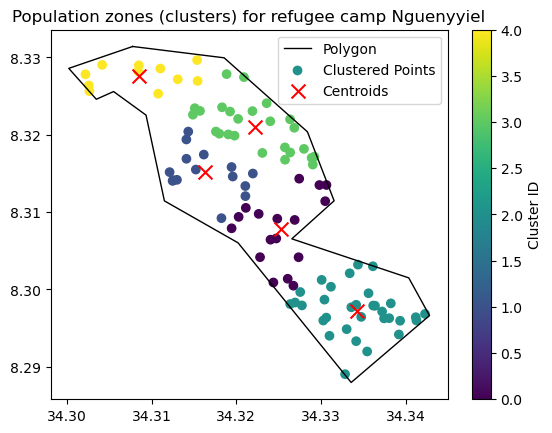

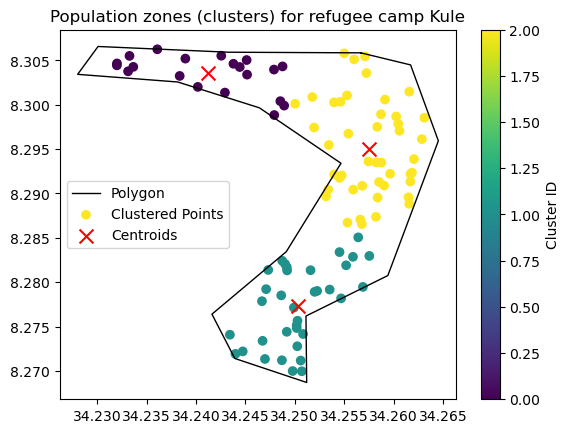

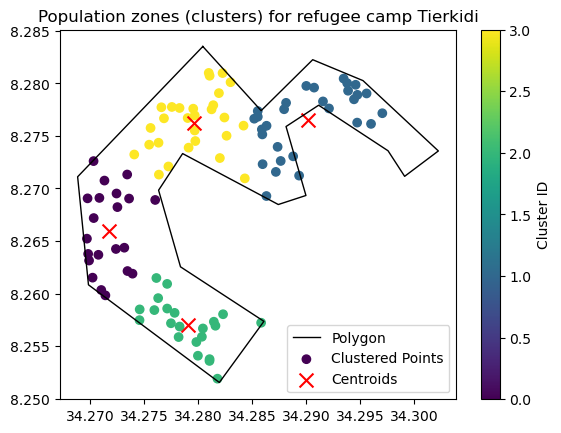

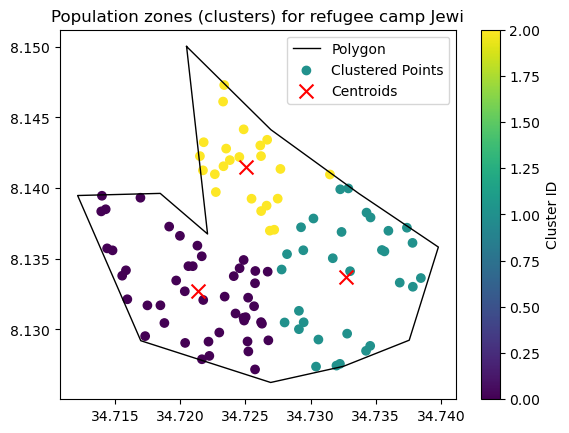

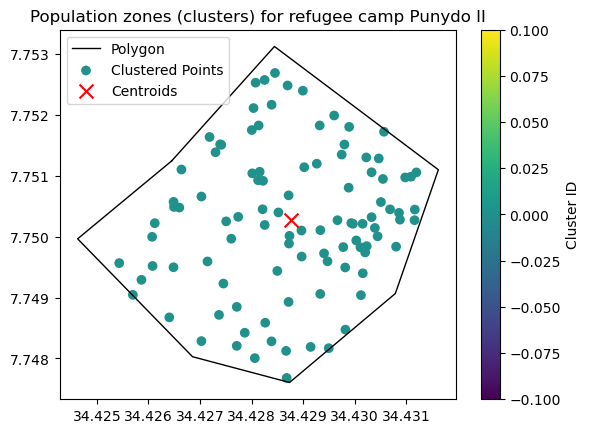

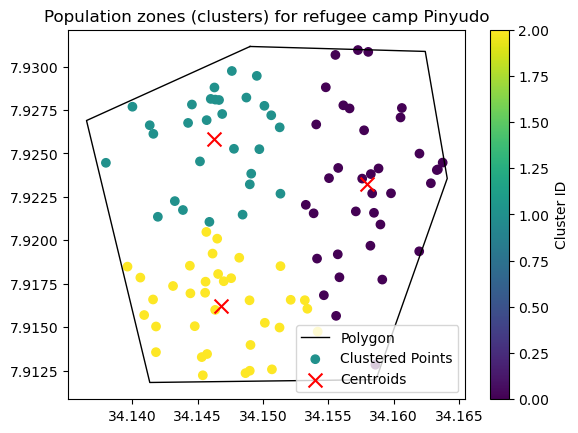

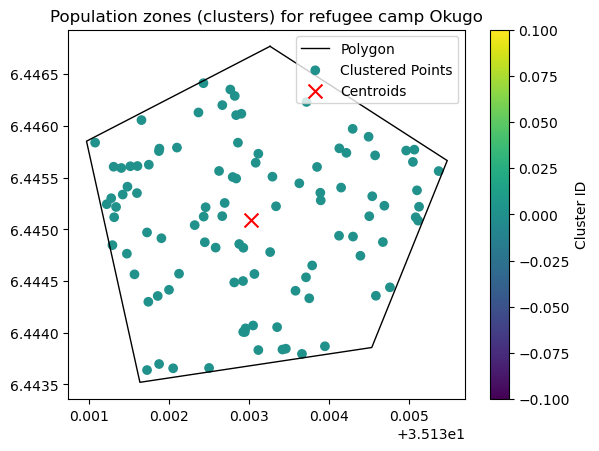

In [10]:
# Plot the results for the different polygon: 
if results:
    for i, result in enumerate(results):
        camps_names = ['Nguenyyiel', 'Kule', 'Tierkidi', 'Jewi', 'Punydo II','Pinyudo', 'Okugo']  # Camp names
        
        # Use camp names for titles
        title = f"Population zones (clusters) for refugee camp {camps_names[i]}"
        
        # Plot the results for the current polygon
        plot_clustering_results(
            result['polygon'], 
            result['points'], 
            result['centroids'], 
            result['labels'],
            title=title
        )


In [11]:
# Initialize an empty list to hold all centroids
all_centroids = []

# Iterate over each entry in the results
for index in range(len(results)):
    # Extract the centroids for the current index
    centroids = results[index]['centroids']
    
    # Append the centroids to the list
    all_centroids.extend(centroids.tolist())  # Convert array to list and extend


In [12]:
population_zones = all_centroids
population_names = ['Nguenyyiel 1', 'Nguenyyiel 2', 'Nguenyyiel 3', 'Nguenyyiel 4', 'Nguenyyiel 5',
               'Kule 1', 'Kule 2', 'Kule 3', 
               'Tierkidi 1', 'Tierkidi 2', 'Tierkidi 3', 'Tierkidi 4', 
               'Jewi 1', 'Jewi 2', 'Jewi 3', 'Pinyudo-II 1',
                'Pinyudo 1', 'Pinyudo 2', 'Pinyudo 3',
                'Okugo 1']
gambella_hospital = np.array([[34.580385,8.242747699999999]])
all_zones = population_zones
all_zones.extend(gambella_hospital.tolist()) 
all_names = population_names
all_names.append('Gambella-Hospital')
"""
Note the order of the refugee camps is: Nguenyyiel, Kule, Tierkidi, Jewi, Pinyudo-II, Pinyudo, Okugo
"""

'\nNote the order of the refugee camps is: Nguenyyiel, Kule, Tierkidi, Jewi, Pinyudo-II, Pinyudo, Okugo\n'

In [13]:
all_names

['Nguenyyiel 1',
 'Nguenyyiel 2',
 'Nguenyyiel 3',
 'Nguenyyiel 4',
 'Nguenyyiel 5',
 'Kule 1',
 'Kule 2',
 'Kule 3',
 'Tierkidi 1',
 'Tierkidi 2',
 'Tierkidi 3',
 'Tierkidi 4',
 'Jewi 1',
 'Jewi 2',
 'Jewi 3',
 'Pinyudo-II 1',
 'Pinyudo 1',
 'Pinyudo 2',
 'Pinyudo 3',
 'Okugo 1',
 'Gambella-Hospital']

In [14]:
# Calculate the Haversine distance matrix (again, I used the Haversine distance for illustrative purposes, but probably CUAMM
# has real data on distances, based on the transportation network in Ethiopia)
def get_dist_matrix(all_zones, all_names):
    dist_matrix = []
    for i in range(len(all_zones)):
        row = []
        for j in range(len(all_zones)):
            distance = haversine(all_zones[i], all_zones[j], unit=Unit.KILOMETERS) 
            row.append(distance)
        dist_matrix.append(row)

    # Creating a DataFrame for the distance matrix
    dist_df = pd.DataFrame(dist_matrix, index=all_names, columns=all_names)
    return dist_matrix, dist_df


# Calculate the distance matrix with the above function and data
distance_matrix = get_dist_matrix(all_zones, all_names)[1]
distance_matrix

,Nguenyyiel 1,Nguenyyiel 2,Nguenyyiel 3,Nguenyyiel 4,Nguenyyiel 5,Kule 1,Kule 2,Kule 3,Tierkidi 1,Tierkidi 2,...,Tierkidi 4,Jewi 1,Jewi 2,Jewi 3,Pinyudo-II 1,Pinyudo 1,Pinyudo 2,Pinyudo 3,Okugo 1,Gambella-Hospital
Nguenyyiel 1,0.000000,1.198395,1.389301,1.255381,2.599768,9.357741,8.785823,7.626905,7.084817,4.846394,...,5.848851,46.874965,48.031156,46.988626,52.444063,39.947987,40.365279,41.106196,192.462493,28.988159
Nguenyyiel 2,1.198395,0.000000,2.578295,0.845526,1.435757,8.426882,8.118759,6.801600,6.709981,4.591242,...,5.431083,48.037043,49.190041,48.145017,53.328339,40.103981,40.483937,41.238629,193.527456,30.099419
Nguenyyiel 3,1.389301,2.578295,0.000000,2.552220,3.989052,10.363800,9.504304,8.536932,7.522402,5.258027,...,6.377925,45.610465,46.772900,45.735404,51.285706,39.577568,40.036843,40.761325,191.138530,27.822670
Nguenyyiel 4,1.255381,0.845526,2.552220,0.000000,1.638975,9.155048,8.941858,7.584588,7.554437,5.422616,...,6.276203,47.614105,48.759183,47.708528,53.698123,40.872981,41.263500,42.014463,193.686628,29.585913
Nguenyyiel 5,2.599768,1.435757,3.989052,1.638975,0.000000,7.812073,7.951215,6.419552,6.987571,5.121388,...,5.714479,49.252972,50.397749,49.346773,54.648982,40.774572,41.114411,41.883121,194.947181,31.210363
Kule 1,9.357741,8.426882,10.363800,9.155048,7.812073,0.000000,2.618527,1.974785,4.841665,5.988982,...,4.952120,55.643917,56.829649,55.812821,54.917498,36.182626,36.311527,37.139561,196.738658,38.127890
Kule 2,8.785823,8.118759,9.504304,8.941858,7.951215,2.618527,0.000000,1.810659,2.591811,4.427181,...,3.248931,54.024603,55.225749,54.226580,52.299073,34.147940,34.339684,35.151902,194.144819,36.832786
Kule 3,7.626905,6.801600,8.536932,7.584588,6.419552,1.974785,1.810659,0.000000,3.102764,4.014835,...,3.002461,53.684570,54.872295,53.857689,53.519120,35.939652,36.139882,36.950095,195.141830,36.223439
Tierkidi 1,7.084817,6.709981,7.522402,7.554437,6.987571,4.841665,2.591811,3.102764,0.000000,2.268016,...,1.284620,51.470244,52.674640,51.679821,50.463082,33.963173,34.253436,35.037339,192.039088,34.388545
Tierkidi 2,4.846394,4.591242,5.258027,5.422616,5.121388,5.988982,4.427181,4.014835,2.268016,0.000000,...,1.179313,49.724062,50.917245,49.908926,50.701714,35.653528,35.998199,36.764636,191.843784,32.417493


In [15]:
# Convert to GeoDataFrame
geometry_popzones = [Point(xy) for xy in all_zones]
gdf_popzones = gpd.GeoDataFrame(geometry=geometry_popzones)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf_popzones.set_crs(epsg=4326, inplace=True)

# Convert the GeoDataFrame to the Web Mercator projection (EPSG:3857)
gdf_popzones = gdf_popzones.to_crs(epsg=3857)
gdf_popzones

,geometry
0,POINT (3821071.064 928076.83)
1,POINT (3820079.667 928903.593)
2,POINT (3822070.252 926892.809)
3,POINT (3820735.232 929558.852)
4,POINT (3819212.256 930305.964)
5,POINT (3811710.973 927599.868)
6,POINT (3812733.8 924649.131)
7,POINT (3813526.222 926642.358)
8,POINT (3815110.071 923375.054)
9,POINT (3817165.271 924555.423)


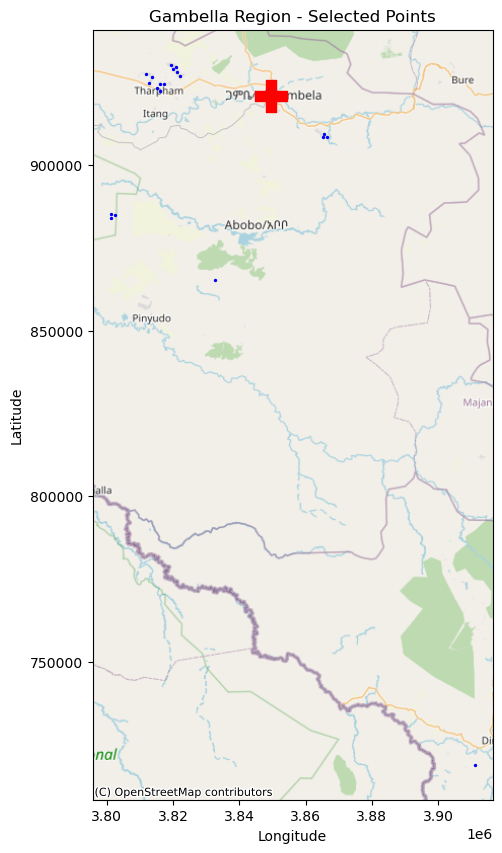

In [16]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))


# Plot all points except the last one
gdf_popzones.iloc[:-1].plot(ax=ax, color='blue', markersize=2)


# Plot the last point with a custom "doctor's cross" marker
last_point = gdf_popzones.iloc[-1]


# Define the doctor's cross marker (red cross)
marker_cross = plt.Line2D((0,1),(0,0), color='red', lw=5) # Use Line2D to create a cross marker


ax.scatter(last_point.geometry.x, last_point.geometry.y, s=500, color='red', marker='P')


# Add basemap from contextily using OpenStreetMap
ctx.add_basemap(ax, crs=gdf_popzones.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)


# Set axis labels and title
ax.set_title('Gambella Region - Selected Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


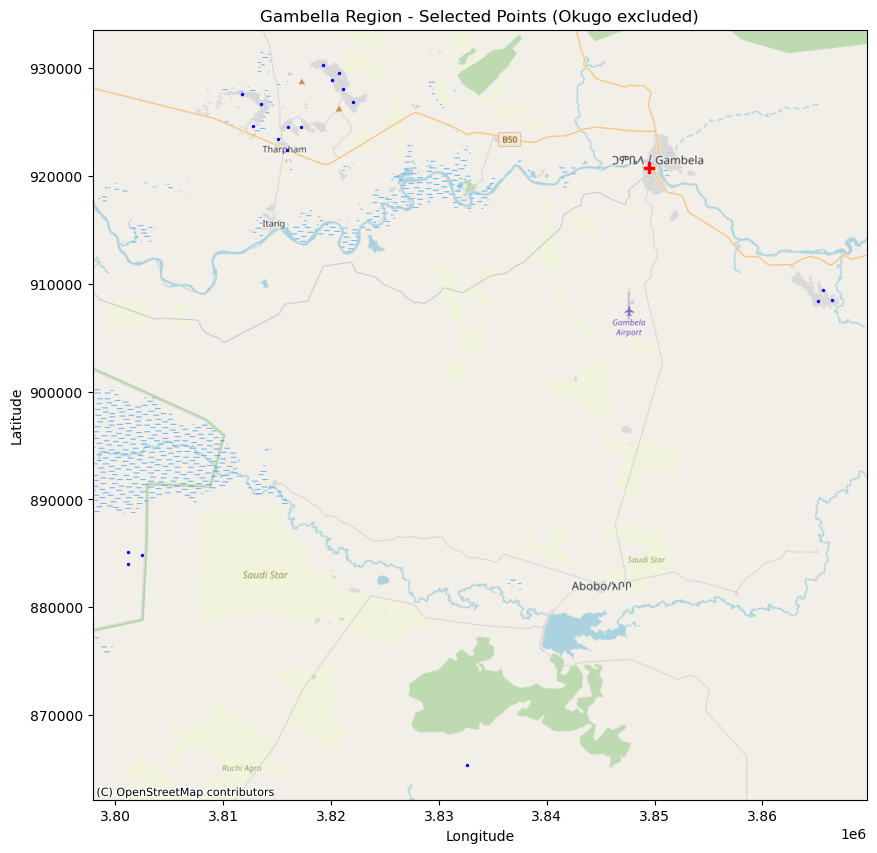

In [20]:
#If I want to disregard Okugo:

# Exclude the one but last point
gdf_popzones_filtered = gdf_popzones.drop(gdf_popzones.index[-2])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all points except the last one
gdf_popzones_filtered.iloc[:-1].plot(ax=ax, color='blue', markersize=2)

# Plot the last point with a custom "doctor's cross" marker
last_point = gdf_popzones_filtered.iloc[-1]

# Coordinates for the last point
x, y = last_point.geometry.x, last_point.geometry.y

# Create the doctor's cross as a combination of two rectangles
cross_size = 1000  # Adjust size of the cross here
cross_width = cross_size / 5  # Adjust width of the cross arms here

# Create horizontal and vertical bars for the cross
horizontal_bar = patches.Rectangle((x - cross_size / 2, y - cross_width / 2), cross_size, cross_width, color='red')
vertical_bar = patches.Rectangle((x - cross_width / 2, y - cross_size / 2), cross_width, cross_size, color='red')

# Add the bars to the plot
ax.add_patch(horizontal_bar)
ax.add_patch(vertical_bar)

# Add basemap from contextily using OpenStreetMap
ctx.add_basemap(ax, crs=gdf_popzones.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis labels and title
ax.set_title('Gambella Region - Selected Points (Okugo excluded)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [21]:
# Note the order of the refugee camps is: Nguenyyiel, Kule, Tierkidi, Jewi, Pinyudo-II, Pinyudo, Okugo (the one in population_zones)

# The population of each refugee camp is:
d = np.array([112000, 52959, 72438, 67896, 11392, 51239, 13954])

# Create the repeated vector
repeated_demand = np.repeat(d, n_clusters)
repeated_clusters = np.repeat(n_clusters, n_clusters)

# We uniformly distribute the demand of each refugee camp over each of the population zones within each refugee camp
demand_per_population_zone = repeated_demand/repeated_clusters


In [22]:
# Now, for each of the specialities, we calculate the demand per population zone
basic_care_demand = np.ceil(demand_per_population_zone)
fertility_rate = 0.035
maternal_demand = np.ceil(demand_per_population_zone*fertility_rate)
under18_rate = 0.66
pediatric_demand = np.ceil(demand_per_population_zone*under18_rate)
tachioma_rate = 0.172
eyecare_demand = np.ceil(demand_per_population_zone*tachioma_rate)

# Create the DataFrame
data = {
    'Basic Care': basic_care_demand,
    'Maternal Care': maternal_demand,
    'Pediatric Care': pediatric_demand,
    'Eye Care': eyecare_demand
}

demand = pd.DataFrame(data)

# Display the DataFrame
print(demand)

    Basic Care  Maternal Care  Pediatric Care  Eye Care
0      22400.0          785.0         14784.0    3853.0
1      22400.0          785.0         14784.0    3853.0
2      22400.0          785.0         14784.0    3853.0
3      22400.0          785.0         14784.0    3853.0
4      22400.0          785.0         14784.0    3853.0
5      17653.0          618.0         11651.0    3037.0
6      17653.0          618.0         11651.0    3037.0
7      17653.0          618.0         11651.0    3037.0
8      18110.0          634.0         11953.0    3115.0
9      18110.0          634.0         11953.0    3115.0
10     18110.0          634.0         11953.0    3115.0
11     18110.0          634.0         11953.0    3115.0
12     22632.0          793.0         14938.0    3893.0
13     22632.0          793.0         14938.0    3893.0
14     22632.0          793.0         14938.0    3893.0
15     11392.0          399.0          7519.0    1960.0
16     17080.0          598.0         11273.0   

In [23]:
"""
In each HP we need to have:
- Basic care: between 10 and 20 supportive staff
- Maternal: between 1 and 2 midwives
- Pediatric: between 2 and 5 nurses
- Eye care: no more than 2 professionals

In each HC we need to have: 
- Basic care: between 20 and 30 supportive staff
- Maternal: between 2 and 5 midwives
- Pediatric: between 4 and 8 nurses
- Eye care: between 1 and 4 professionals

At the hospital we need to have:
- Basic care: more than 50 supportive staff
- Maternal: more than 5 midwives
- Pediatric: between 6 and 12 nurses
- Eye care: between 3 and 6 professionals
"""

lb_specialists_HPs = [10, 1, 2, 0] 
ub_specialists_HPs = [20, 2, 5, 2]
lb_specialists_HCs = [20, 2, 4, 1]
ub_specialists_HCs = [30, 5, 8, 4]
lb_specialists_Hosp = [50, 5, 6, 3]
ub_specialists_Hosp = [1000, 1000, 12, 6]


# Combine the lists into a 2D matrix
lb_specialists = np.array([lb_specialists_HPs, lb_specialists_HCs, lb_specialists_Hosp])
ub_specialists = np.array([ub_specialists_HPs, ub_specialists_HCs, ub_specialists_Hosp])

# The number of specialists to locate (per 'level of service') is s_l
s_l = [197, 14, 19, 12]


In [24]:
# Service rates for each professional (to define somehow the capacity of the system)
# rates expressed in patients/day per professional
rates_specialists_HPs = [42, 28, 28, 42]
rates_specialists_HCs = [42, 10, 28, 14]
rates_specialists_Hosp = [42, 4, 28, 14]

rates_specialists = np.array([rates_specialists_HPs, rates_specialists_HCs, rates_specialists_Hosp])

In [25]:
facilities_to_locate = [4,2,1]
rates_referrals = np.array([[0,0.1,0], [0,0,0.3], [0,0,0]])


In [26]:
# Function to get camps within a specified distance

def within_distance(camps_coord, camps_names, max_distance):
    distance_matrix = get_dist_matrix(camps_coord, camps_names)[1]
    camps_within_distance = {}
    for i in camps_names:
        within_distance_aux = distance_matrix[i][distance_matrix[i] <= max_distance].index.tolist()
        within_distance_aux.remove(i)  # Remove the camp itself from the list
        camps_within_distance[i] = within_distance_aux
    # Create a mapping from names to indices
    name_to_index = {name: index + 1 for index, name in enumerate(camps_within_distance.keys())}
    # Create a new dictionary with indices
    indexed_dict = {name_to_index[key]: [name_to_index[neighbor] for neighbor in neighbors]
                for key, neighbors in camps_within_distance.items()}
    return camps_within_distance, indexed_dict

zones_within_d1  = within_distance(all_zones, all_names, max_distance=50)[0]
#zones_within_d1
facilities_within_d2  = within_distance(all_zones, all_names, max_distance=100)[0]
#facilities_within_d2
indexed_dict_zones = within_distance(all_zones, all_names, max_distance=50)[1]
#indexed_dict_zones
indexed_dict_facilities = within_distance(all_zones, all_names, max_distance=100)[1]
#indexed_dict_facilities

d_dict = {index + 1: value for index, value in enumerate(d)}
d_dict

{1: np.int64(112000),
 2: np.int64(52959),
 3: np.int64(72438),
 4: np.int64(67896),
 5: np.int64(11392),
 6: np.int64(51239),
 7: np.int64(13954)}